In [ ]:
# Import all modules
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pytz
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Define the BLSTM model
class BLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [ ]:
# Load and preprocess data
data_dir = "path/to/data-directory"  # Update this path
input_features = ['time_s', 'lat_rad', 'lon_rad', 'flight_id']
target_features = ['time_s', 'lat_rad', 'lon_rad', 'flight_id']

flight_data = pd.read_csv(data_dir + "path/to/flight-data")

# full_dataset = pd.concat(flight_data, ignore_index=True)
full_dataset = flight_data[['time_s', 'lat_rad', 'lon_rad', 'flight_id']]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(full_dataset)

# Split the data into train and test sets
train_data, test_data = train_test_split(normalized_data, test_size=0.2, shuffle=False)

In [ ]:
# Define model and optimizer
input_size = len(input_features)
hidden_size = 128 # Tune or adjust this value
output_size = len(target_features)

model = BLSTMModel(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 150 # Adjust this to your desired sliding window size
batch_size = 256 # Adjust this to your desired sliding window size
sliding_window_size = 20  # Adjust this to your desired sliding window size
step_size = 1  # Adjust this to your desired step size
losses = []
rmse_values = []
mae_values = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    epoch_rmse = 0
    epoch_mae = 0

    for batch_start in range(0, len(train_data) - (sliding_window_size * batch_size), step_size * batch_size):
        batch_data = train_data[batch_start:batch_start + (sliding_window_size * batch_size):step_size]

        batch_X = batch_data[:, :input_size].astype(np.float32)
        batch_y = batch_data[:, :output_size].astype(np.float32)

        batch_X = torch.tensor(batch_X, dtype=torch.float32).view(batch_size, sliding_window_size, input_size)
        batch_y = torch.tensor(batch_y, dtype=torch.float32).view(batch_size, sliding_window_size, output_size)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate RMSE and MAE
        batch_rmse = mean_squared_error(batch_y.view(-1, output_size).detach().numpy(), outputs.view(-1, output_size).detach().numpy(), squared=False)
        batch_mae = mean_absolute_error(batch_y.view(-1, output_size).detach().numpy(), outputs.view(-1, output_size).detach().numpy())
        epoch_rmse += batch_rmse
        epoch_mae += batch_mae

    avg_loss = total_loss / ((len(train_data) - (sliding_window_size * batch_size)) // (step_size * batch_size))
    avg_rmse = epoch_rmse / ((len(train_data) - (sliding_window_size * batch_size)) // (step_size * batch_size))
    avg_mae = epoch_mae / ((len(train_data) - (sliding_window_size * batch_size)) // (step_size * batch_size))

    losses.append(avg_loss)
    rmse_values.append(avg_rmse)
    mae_values.append(avg_mae)

    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.6f}, Avg RMSE: {avg_rmse:.6f}, Avg MAE: {avg_mae:.6f}')

Epoch [1/150], Avg Loss: 0.158101, Avg RMSE: 0.180811, Avg MAE: 0.094700
Epoch [2/150], Avg Loss: 0.113927, Avg RMSE: 0.084549, Avg MAE: 0.030599
Epoch [3/150], Avg Loss: 0.097960, Avg RMSE: 0.065295, Avg MAE: 0.021415
Epoch [4/150], Avg Loss: 0.084655, Avg RMSE: 0.057677, Avg MAE: 0.018488
Epoch [5/150], Avg Loss: 0.074398, Avg RMSE: 0.055097, Avg MAE: 0.018901
Epoch [6/150], Avg Loss: 0.064397, Avg RMSE: 0.052631, Avg MAE: 0.018200
Epoch [7/150], Avg Loss: 0.054858, Avg RMSE: 0.048830, Avg MAE: 0.017189
Epoch [8/150], Avg Loss: 0.046829, Avg RMSE: 0.047162, Avg MAE: 0.017148
Epoch [9/150], Avg Loss: 0.039065, Avg RMSE: 0.042878, Avg MAE: 0.015562
Epoch [10/150], Avg Loss: 0.032751, Avg RMSE: 0.040919, Avg MAE: 0.015124
Epoch [11/150], Avg Loss: 0.026725, Avg RMSE: 0.038127, Avg MAE: 0.014375
Epoch [12/150], Avg Loss: 0.021597, Avg RMSE: 0.035482, Avg MAE: 0.013664
Epoch [13/150], Avg Loss: 0.017466, Avg RMSE: 0.032971, Avg MAE: 0.012804
Epoch [14/150], Avg Loss: 0.013595, Avg RMSE: 0

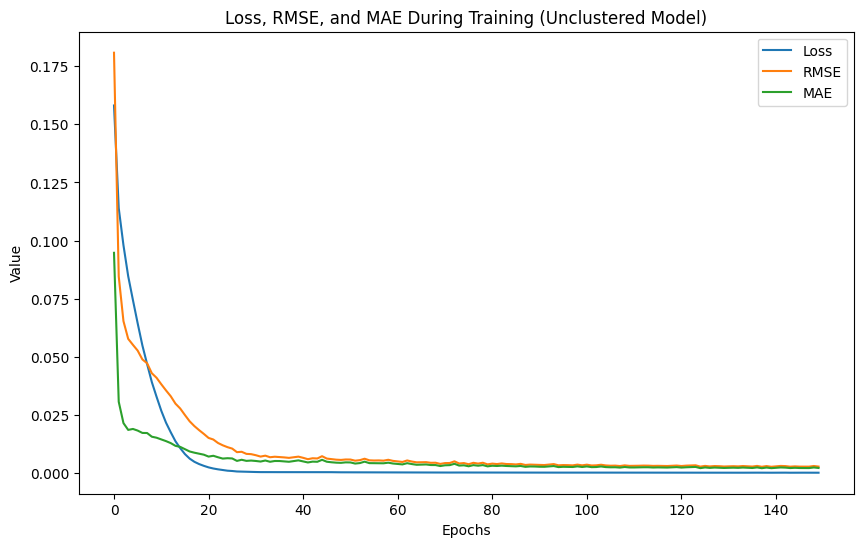

In [ ]:
# Plotting the Loss, RMSE, and MAE
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.plot(rmse_values, label='RMSE')
plt.plot(mae_values, label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Loss, RMSE, and MAE During Training (Unclustered Model)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load the input data from a CSV file
input_csv = data_dir + "path/to/flight-data" #Change this path to your flight-data dir
input_data = pd.read_csv(input_csv)

# Convert input_data to a NumPy array and normalize it using the same scaler
input_data_array = input_data[input_features].values
input_data_array = scaler.transform(input_data_array)

# Convert input_data_array to a tensor
input_data_tensor = torch.tensor(input_data_array, dtype=torch.float32).unsqueeze(0)

# Generate predictions
prediction_steps = # Adjust the number of steps as needed
predicted_sequence = []

with torch.no_grad():
    for _ in range(prediction_steps):
        output = model(input_data_tensor)
        predicted_point = output[:, -1]
        denormalized_point = scaler.inverse_transform(predicted_point)

        # Prepare the next input using the predicted point
        next_input = torch.tensor(denormalized_point, dtype=torch.float32).unsqueeze(0)
        input_data_tensor = torch.cat((input_data_tensor, next_input), dim=1)
        predicted_sequence.append(denormalized_point[0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Convert predicted_sequence to a NumPy array and save to CSV
predicted_data = np.array(predicted_sequence)
predicted_df = pd.DataFrame(predicted_data, columns=target_features)

# Save by timestamp
timezone = pytz.timezone('Asia/Bangkok')  # GMT+7 (Indochina Time)
current_datetime = datetime.now(timezone).strftime('%Y-%m-%d_%H:%M:%S')
file_name = f'predicted_flight_data_{current_datetime}.csv'
save_path = f'{data_dir}/results/' + file_name
predicted_df.to_csv(save_path, index=False)

print(f'CSV file saved to: {save_path}')

CSV file saved to: gdrive/Shareddrives/TA_Ojan_Bismillah/results/predicted_flight_data_2023-08-23_14:02:48.csv
